<a href="https://colab.research.google.com/github/ritikverma2000/Akshi/blob/aakash-transfer-learning/Aakash_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [ ]:
pwd

'/content/gdrive/My Drive/kaggle'

In [ ]:
#changing the working directory
%cd /content/gdrive/MyDrive/kaggle/content/

/content/gdrive/MyDrive/kaggle/content


In [ ]:
pwd


'/content/gdrive/My Drive/kaggle'

In [ ]:
pwd

'/content/gdrive/My Drive/kaggle'

In [ ]:
!kaggle datasets download -d gauravsharma99/fer13-cleaned-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content/gdrive/My Drive/kaggle. Or use the environment method.


In [ ]:
!ls

content


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: FER13 Cleaned Dataset/Happy/Training_67165087.jpg  
  inflating: FER13 Cleaned Dataset/Neutral/Training_14221663.jpg  
  inflating: FER13 Cleaned Dataset/Neutral/Training_26296830.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_31182532.jpg  
  inflating: FER13 Cleaned Dataset/Neutral/Training_30253107.jpg  
  inflating: FER13 Cleaned Dataset/Neutral/Training_27097580.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_30623479.jpg  
  inflating: FER13 Cleaned Dataset/Neutral/Training_2004636.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_69914917.jpg  
  inflating: FER13 Cleaned Dataset/Neutral/Training_16652700.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_34665953.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_65796180.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_61144858.jpg  
  inflating: FER13 Cleaned Dataset/Happy/Training_37782864.jpg  
  inflating: FER13 Cleaned D

In [ ]:
INPUT_PATH = "/content/gdrive/MyDrive/kaggle/content/FER13 Cleaned Dataset"



In [ ]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    
    for f in os.listdir(INPUT_PATH +"/"+ dir_ ):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

Happy has 6834 number of images
disgust has 380 number of images
fear has 2535 number of images
Neutral has 4295 number of images
Angry has 2832 number of images

total images are 16876


In [ ]:
TOP_EMOTIONS = ["Happy", "Neutral", "disgust"]
total_images -= 5367
total_images

11509

In [ ]:
!pip install scikit-plot

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH +"/"+ dir_ ):
            img_arr[i] = cv2.imread(INPUT_PATH +"/"+ dir_ +"/"+ f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Happy images to numpy arrays
loaded all disgust images to numpy arrays
loaded all Neutral images to numpy arrays


((11509, 48, 48, 3), array([0., 0., 0., ..., 2., 2., 2.]))

In [ ]:
label_to_text

{0: 'Happy', 1: 'disgust', 2: 'Neutral'}

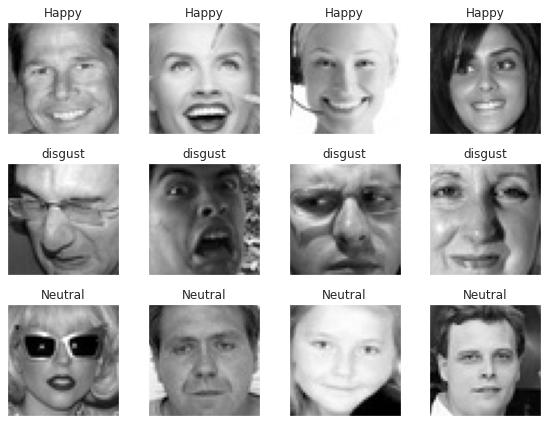

In [ ]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(11509, 3)

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10358, 48, 48, 3), (1151, 48, 48, 3), (10358, 3), (1151, 3))

In [ ]:
del img_arr
del img_label

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

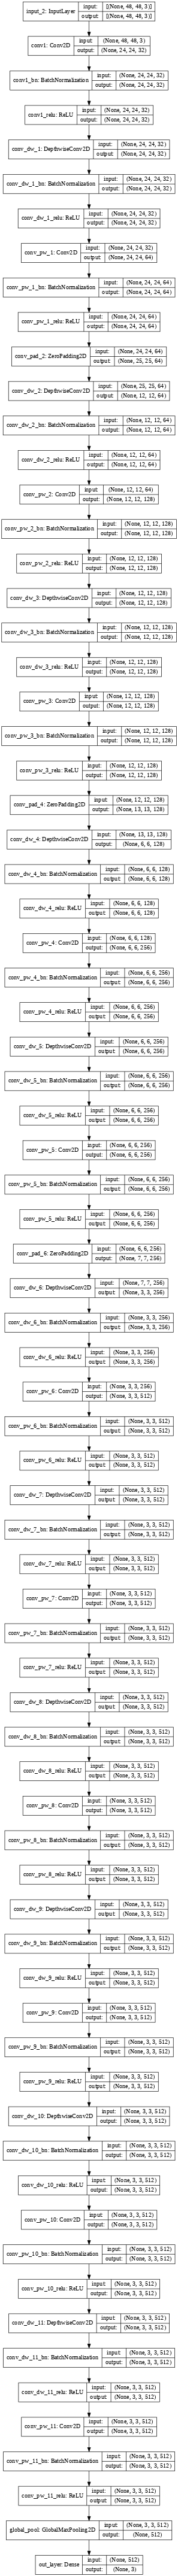

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
batch_size = 35
epochs = 35

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
295/295 [==============================] - 18s 53ms/step - loss: 0.8642 - accuracy: 0.6914 - val_loss: 1.5248 - val_accuracy: 0.7220
Epoch 2/35
295/295 [==============================] - 15s 49ms/step - loss: 0.5072 - accuracy: 0.8054 - val_loss: 0.5788 - val_accuracy: 0.7741
Epoch 3/35
295/295 [==============================] - 15s 50ms/step - loss: 0.4613 - accuracy: 0.8191 - val_loss: 0.3609 - val_accuracy: 0.8671
Epoch 4/35
295/295 [==============================] - 15s 49ms/step - loss: 0.4343 - accuracy: 0.8300 - val_loss: 0.4805 - val_accuracy: 0.8123
Epoch 5/35
295/295 [==============================] - 15s 50ms/step - loss: 0.4029 - accuracy: 0.8394 - val_loss: 0.3275 - val_accuracy: 0.8732
Epoch 6/35
295/295 [==============================] - 15s 49ms/step - loss: 0.4053 - accuracy: 0.8377 - val_loss: 0.3346 - val_accuracy: 0.8688
Epoch 7/35
295/295 [==============================] - 15s 49ms/step - loss: 0.3846 - accuracy: 0.8475 - val_loss: 0.3605 - val_accuracy:

In [ ]:
model_yaml = model.to_json()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

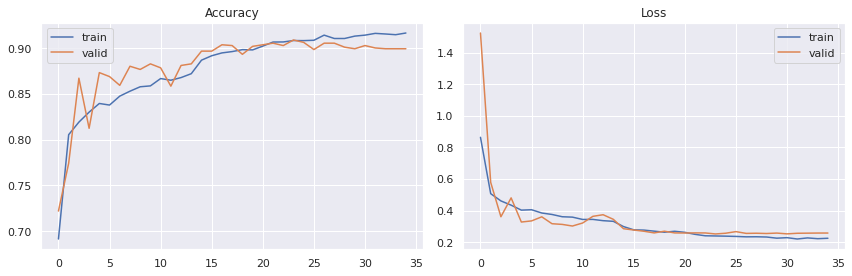

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [ ]:
label_to_text

{0: 'Happy', 1: 'disgust', 2: 'Neutral'}

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 0, 'Neutral': 2, 'disgust': 1}

test accuracy: 90.8775 %


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       683
           1       0.72      0.76      0.74        38
           2       0.88      0.90      0.89       430

    accuracy                           0.91      1151
   macro avg       0.85      0.86      0.85      1151
weighted avg       0.91      0.91      0.91      1151



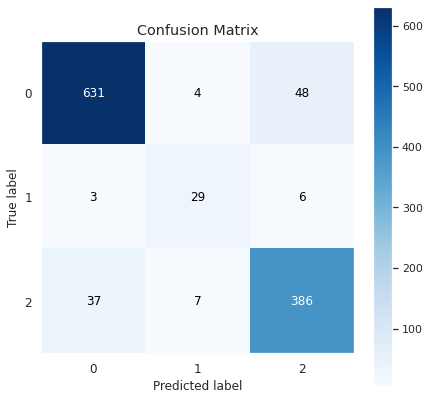

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

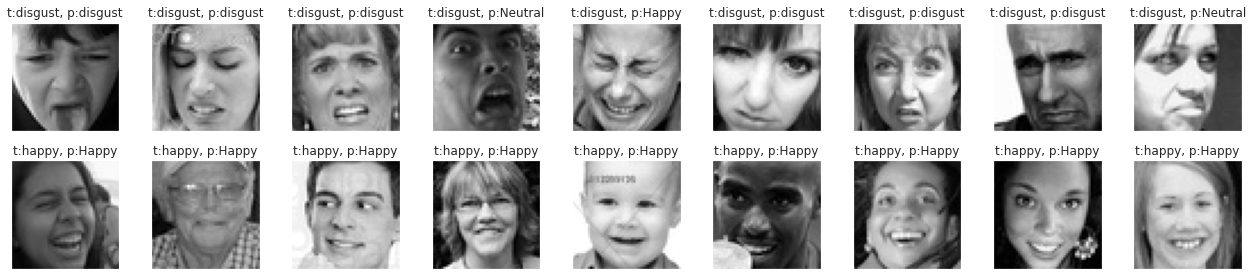

In [ ]:
np.random.seed(42)
disgust_imgs = np.random.choice(np.where(y_test[:, text_to_label["disgust"]]==1)[0], size=9, replace=False)
happy_imgs = np.random.choice(np.where(y_test[:, text_to_label["Happy"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (disgust_idx, happy_idx) in enumerate(zip(disgust_imgs, happy_imgs)):
        sample_img = X_test[disgust_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:disgust, p:{pred}")

        sample_img = X_test[happy_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:happy, p:{pred}")

        pyplot.tight_layout()